In [1]:
# IMPORTING REQUIRED LIBRARIES
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# READING DATA
data = pd.read_csv('online_retail_II.csv')
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# CONVERT PURCHASE DATE TO DATETIME FORMAT
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [8]:
# CALACULATE RECENCY
data_recency = data.groupby(by='Customer ID', as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = data_recency['LastPurchaseDate'].max()
data_recency['Recency'] = data_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
data_recency.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


In [11]:
# CALCULATE FREQUENCY
frequency_data = data.drop_duplicates().groupby(by='Customer ID', as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
frequency_data.head()

,CustomerID,Frequency
0,12346.0,47
1,12347.0,222
2,12348.0,51
3,12349.0,180
4,12350.0,17


In [13]:
# CALCULATE MONETARY VALUE
data['TotalAmount']= data['Quantity'] * data['Price']
monetary_data = data.groupby(by='Customer ID', as_index=False)['TotalAmount'].sum()
monetary_data.columns = ['CustomerID', 'MonetaryValue']
monetary_data.head()

,CustomerID,MonetaryValue
0,12346.0,-64.68
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4404.54
4,12350.0,334.40


In [21]:
# MERGE RECENCY, FREQUENCY, AND MONETARY DATA
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(columns=['LastPurchaseDate'])
rfm_data.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,325,47,-64.68
1,12347.0,1,222,5633.32
2,12348.0,74,51,2019.40
3,12349.0,18,180,4404.54
4,12350.0,309,17,334.40


In [22]:
# RANK CUSTOMERS BASED ON RECENCY, FREQUENCY, AND MONETARY VALUE
rfm_data['R_rank']= rfm_data['Recency'].rank(ascending = False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending = True)
rfm_data['M_rank'] = rfm_data['MonetaryValue'].rank(ascending = True)

In [23]:
# NORMALIZE THE RANKS
rfm_data['R rank_norm'] = (rfm_data['R_rank'] / rfm_data['R_rank'].max()) * 100
rfm_data['F rank_norm'] = (rfm_data['F_rank'] / rfm_data['F_rank'].max()) * 100
rfm_data['M rank_norm'] = (rfm_data['M_rank'] / rfm_data['M_rank'].max()) * 100

In [ ]:
# DROP INDIVIDUAL RANK COLUMNS TO AVOID CONFUSION AND CALCULATE RFM SCORE
rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
rfm_data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R rank_norm,F rank_norm,M rank_norm
0,12346.0,325,47,-64.68,29.490662,46.953888,0.875126
1,12347.0,1,222,5633.32,98.327674,84.432851,90.794345
2,12348.0,74,51,2019.40,54.660441,49.293167,73.157186
3,12349.0,18,180,4404.54,80.178268,80.587344,87.613598
4,12350.0,309,17,334.40,30.747029,21.028273,25.782565


In [ ]:
# CALCULATE RFM SCORE
rfm_data['RFM_Score']= 0.15 * rfm_data['R rank_norm'] + 0.30 * rfm_data['F rank_norm'] + 0.55 * rfm_data['M rank_norm']
rfm_data['RFM_Score'] *= 100
rfm_data = rfm_data.round({'RFM_Score': 2})


In [30]:
# DISPLAY RFM SCORE AND CUSTOMER ID
rfm_data[['CustomerID', 'RFM_Score']].head(7)

,CustomerID,RFM_Score
0,12346.0,1899.25
1,12347.0,9001.30
2,12348.0,6322.40
3,12349.0,8438.95
4,12350.0,2510.05
5,12351.0,2415.60
6,12352.0,7077.30


In [35]:
# SEGMENT CUSTOMERS BASED ON RFM SCORE
rfm_data['CustomerID_Segment'] = np.where(rfm_data['RFM_Score'] >= 9000, "Top Customers", np.where(rfm_data['RFM_Score'] >= 8000, "High Value Customers", np.where(rfm_data['RFM_Score'] >= 7000, "Mid Value Customers",np.where(rfm_data['RFM_Score'] >= 6000, "Low Value Customers", "Lost Customers"))))

In [36]:
# DISPLAY CUSTOMER SEGMENTATION
rfm_data[['CustomerID', 'RFM_Score', 'CustomerID_Segment']].head(100)

,CustomerID,RFM_Score,CustomerID_Segment
0,12346.0,1899.25,Lost Customers
1,12347.0,9001.30,Top Customers
2,12348.0,6322.40,Low Value Customers
3,12349.0,8438.95,High Value Customers
4,12350.0,2510.05,Lost Customers
...,...,...,...
95,12441.0,2302.50,Lost Customers
96,12442.0,2601.05,Lost Customers
97,12443.0,2732.00,Lost Customers
98,12444.0,8497.75,High Value Customers


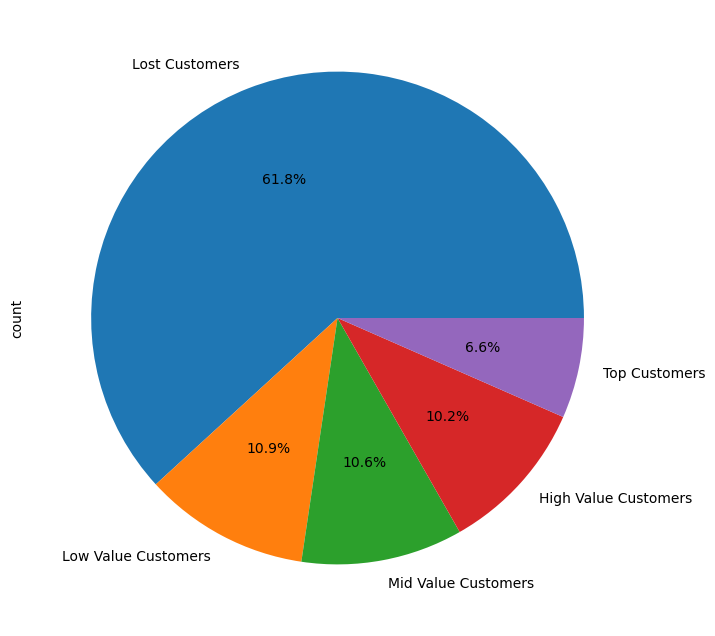

In [37]:
# VISUALIZE CUSTOMER SEGMENTS WITH A PIE CHART
rfm_data['CustomerID_Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8))
plt.show()

In [38]:
# SAVE THE FINAL DATA FOR POWER BI ANALYSIS
rfm_data.to_csv('rfm_for_powerbi.csv', index=False)
print("RFM analysis complete. 'rfm_for_powerbi.csv' is ready for Power BI.")

RFM analysis complete. 'rfm_for_powerbi.csv' is ready for Power BI.
